# Cryptocurrency Time Series Forecasting using ARIMA

# Import Libraries

In [128]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 7)

import seaborn as sns
from datetime import datetime, timedelta

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

# Import Dataset

In [129]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
btc = pd.read_csv('../data/Bitcoin/BTC-USD-NEW.csv', parse_dates = ['date'], index_col = 'date', date_parser = dateparse)
btc = btc[btc.columns[1:]]
btc.head()

,open,high,low,close,adj_close,volume
date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [130]:
btc.tail()

,open,high,low,close,adj_close,volume
date,,,,,,
2023-03-17,25055.123047,27787.812500,24955.169922,27423.929688,27423.929688,50730261335
2023-03-18,27448.117188,27725.953125,26636.261719,26965.878906,26965.878906,35723036817
2023-03-19,26969.503906,28440.560547,26907.716797,28038.675781,28038.675781,37769448859
2023-03-20,28041.601563,28527.724609,27242.880859,27767.236328,27767.236328,44774027664
2023-03-21,27784.175781,27980.882813,27737.007813,27901.240234,27901.240234,43486908416


# Monthly Forecasting

In [47]:
# Resampling to monthly frequency
btc_month = btc.resample('M').mean()

### Stationarity check and Seasonal decomposition

If a time series is stationary, it implies relatively constant mean and constant variance over time in the data. This is important as a consideration in time series forecasting

Dickey_Fuller test: p=0.497078


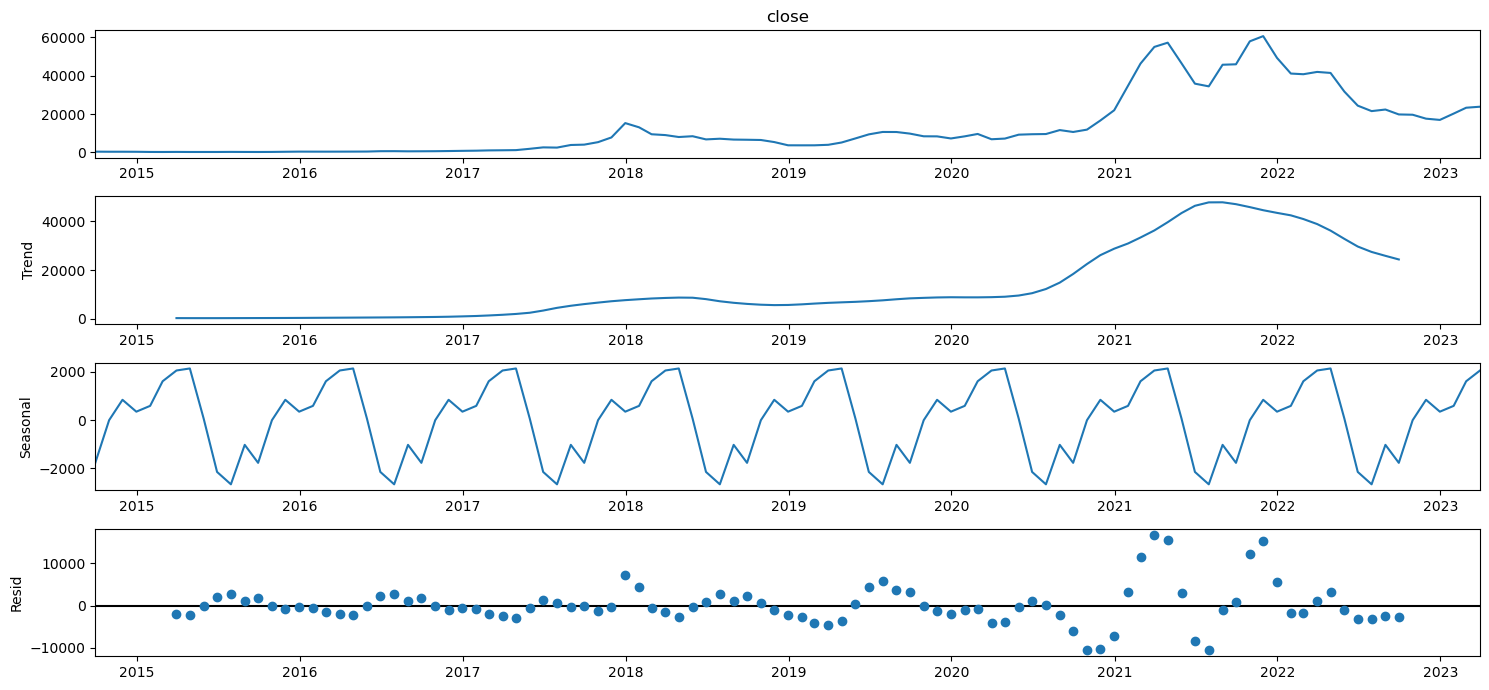

In [50]:
seasonal_decompose(btc_month.close).plot()
print('Dickey_Fuller test: p=%f' % adfuller(btc_month.close)[1])
plt.show()

The p-value indicates that series is not stationary with 49.71% confidence

### Box-Cox Transformation (Power Transform)

The Box-Cox transformation is typically used to suppress some of the variance in the time series. It is a family of power transformations indexed by a parameter lambda. Whenever you use it, the parameter needs to be estimated from the data.

$$
y'(λ) = \begin{cases}
  \frac{y^\lambda - 1}{\lambda} & \text{if}\ \lambda \neq 0 \\
  \log{(y)} & \text{if}\ \lambda = 0
\end{cases}
$$

Diagnostics from ARIMA modeling can then be used to decide if differencing or seasonal differencing might be useful to remove polynomial trends or seasonal trends respectively. After that the result might be an ARMA model that is stationary. If diagnostics confirm the orders p and q for the ARMA model, the AR and MA parameters can then be estimated

In [52]:
# Box-Cox Transformations
btc_month['close_box'], lmbda = stats.boxcox(btc_month.close)
print('Dickey_Fuller test: p=%f' % adfuller(btc_month.close_box)[1])

Dickey_Fuller test: p=0.661977


The p-value states that series is still not stationary

### Differencing

When building models to forecast time series data (like ARIMA), another pre-processing step is differencing the data (calculating sequentially $x_{t}$ - $x_{t-1}$) until we get to a point where the series is stationary. Models account for oscillations but not for trends, and therefore, accounting for trends by differencing allows us to use the models that account for oscillations.

Once the model has been constructed, we can account for trends separaly, by adding the trends component-wise


##### Seasonal differentiation

One method of differencing data is seasonal differencing, which involves computing the difference between an observation and the corresponding observation in the previous year.

In [53]:
# Seasonal differentiation (12 months)
btc_month['box_diff_seasonal_12'] = btc_month.close_box - btc_month.close_box.shift(12)
print('Dickey-Fuller test: p=%f' % adfuller(btc_month.box_diff_seasonal_12[12:])[1])

Dickey-Fuller test: p=0.582330


The p-value indicates that series is still not stationary

In [54]:
# Seasonal differentiation (3 months)
btc_month['box_diff_seasonal_3'] = btc_month.close_box - btc_month.close_box.shift(3)
print('Dickey-Fuller test: p=%f' % adfuller(btc_month.box_diff_seasonal_3[3:])[1])

Dickey-Fuller test: p=0.006681


The p-value indicates that series is stationary as the computed p-value is lower than the significance level alpha = 0.05

##### Regular differentiation

For the 12-month time series, it is necessary to difference the data a second time to obtain a stationary time series, which is referred to as second order differencing

Dickey-Fuller test: p=0.000313


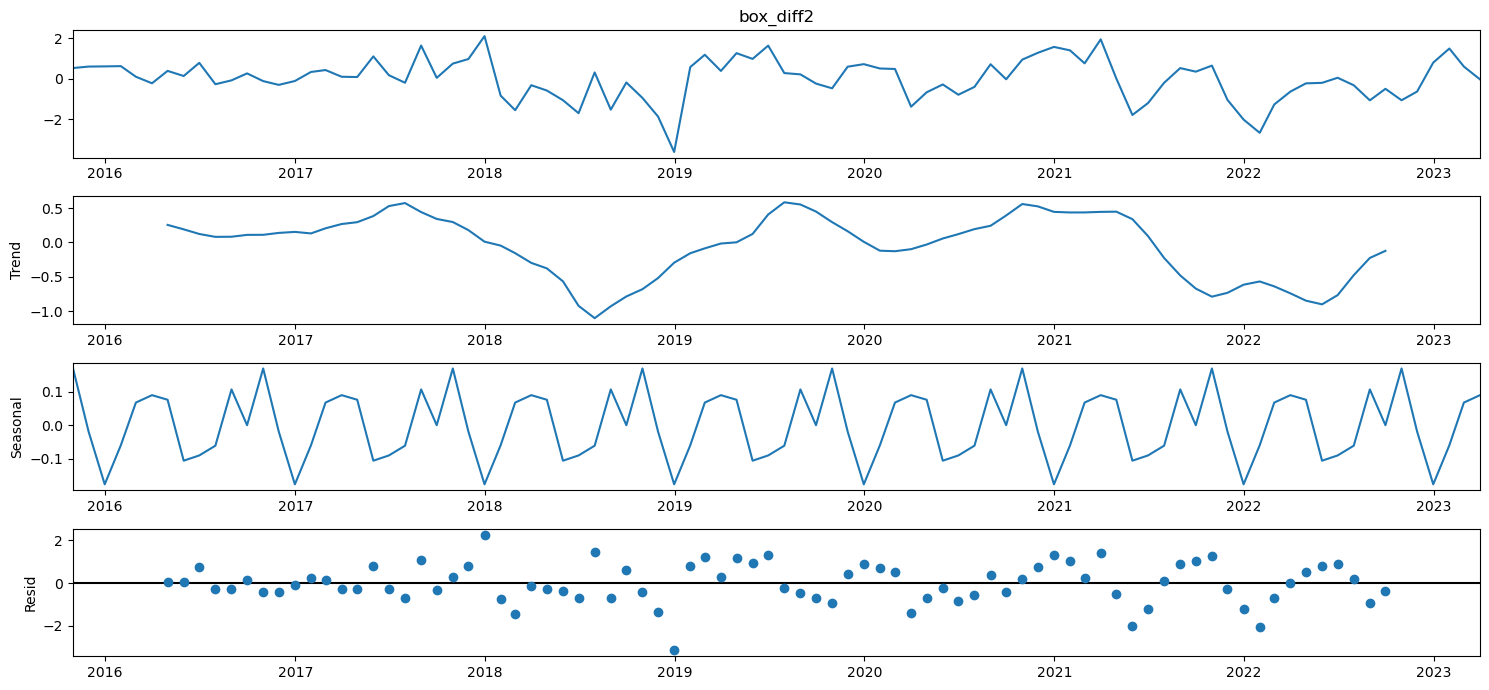

In [55]:
# Regular differentiation
btc_month['box_diff2'] = btc_month.box_diff_seasonal_12 - btc_month.box_diff_seasonal_12.shift(1)

# STL-decomposition
seasonal_decompose(btc_month.box_diff2[13:]).plot()
print('Dickey-Fuller test: p=%f' % adfuller(btc_month.box_diff2[13:])[1])

plt.show()

The p-value indicates that series is stationary as the computed p-value is lower than the significance level alpha = 0.05

### Autocorrelation

Autocorrelation is the correlation of a time series with the same time series lagged. It summarizes the strength of a relationship with an observation in a time series with observations at prior time steps.

We create autocorrelation factor (ACF) and partial autocorrelation factor (PACF) plots to identify patterns in the above data which is stationary on both mean and variance. The idea is to identify presence of AR and MA components in the datasets.

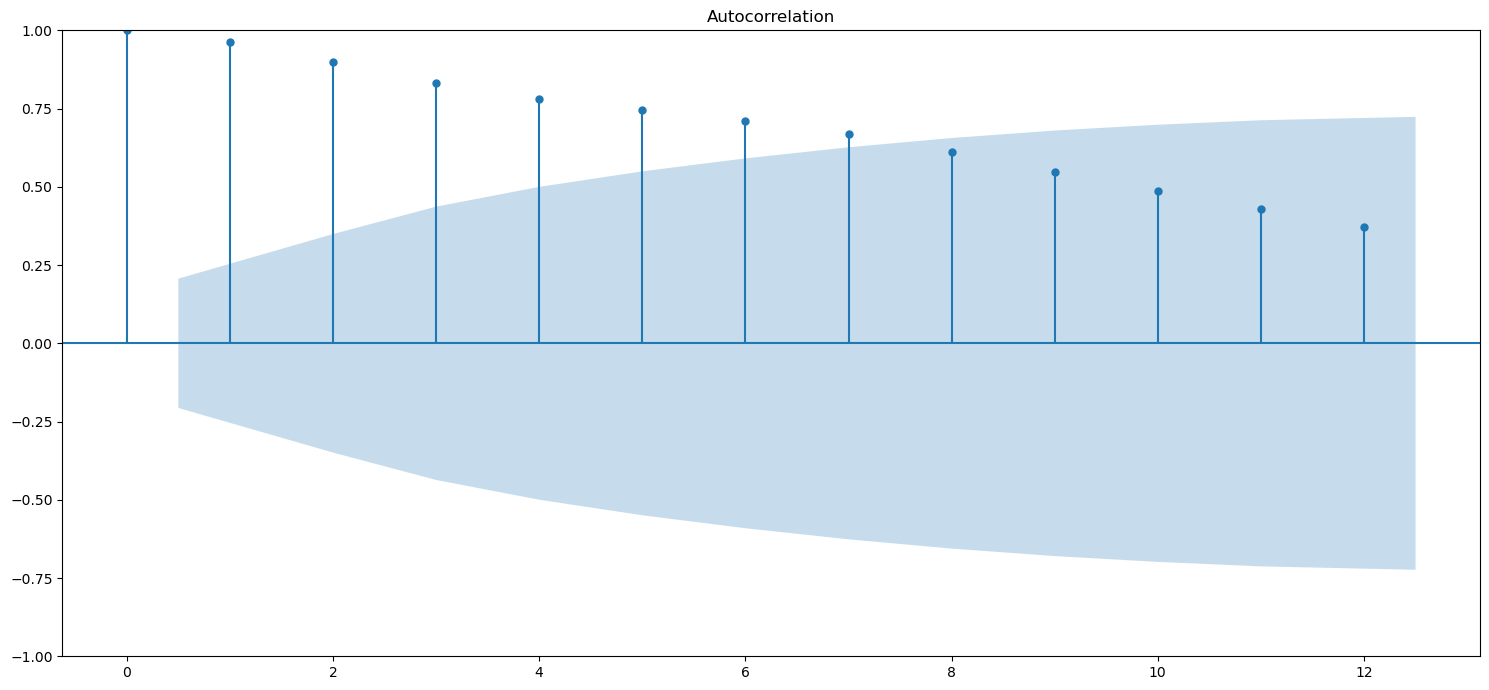

In [60]:
plot_acf(btc_month.close[13:].values.squeeze(), lags = 12)

plt.tight_layout()
plt.show()

Let's try out autocorrelation on the differences to produce PACF

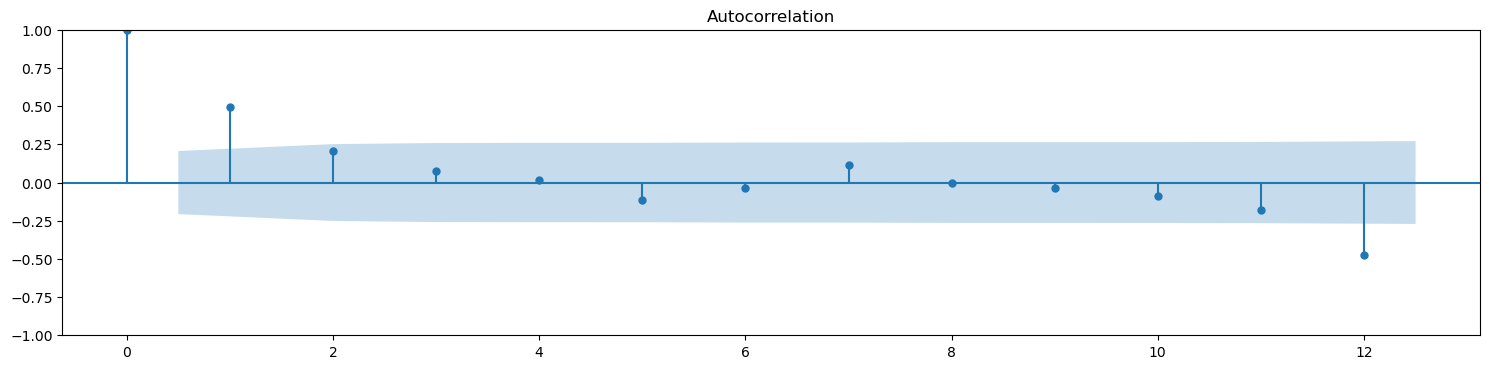

In [114]:
# Initial approximation of parameters using Autocorrelation and Partial Autocorrelation Plots
ax = plt.subplot(211)
# Plot the autocorrelation fuction
# sm.graphics.tsa.plot.acf(btc_month.box_diff2[13:].values.squeeze(), lags = 48, ax = ax)
plot_acf(btc_month.box_diff2[13:].values.squeeze(), lags = 12, ax = ax)
plt.tight_layout()
plt.show()

In ACF, there is a positive correlation with all the lags that is significant throughout.

While in PACF, only the first three lags are significant

A good starting point for that AR and MA parameter of the model may be 3

# ARIMA Model

The ARIMA model is a time series machine learning model for forecasting time series. It predicts future values by examining the differences between values in the time series. An ARIMA model consists of 3 components: Auto Regression (AR), Integrated (I) and Moving Average (MA), each of which is a parameter. The standard notation for these parameters are p, d, and q. These parameters account for seasonality, trend, and noise in datasets The combinations of the parameters indicate the type of ARIMA model used. Specifically:

p - the number of lag observations to include in the model, or lag order (AR)

d - the number of times that the raw observations are differenced, or the degree of differencing  (I)

q - the size of the moving average window, also called the order of moving average (MA) 

A linear regression model is constructed including the specified number and type of terms, and the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression affect the regression model. A value of 0 for a parameter indicates to not use that element of the model

##### Parameter Selection

We will iteratively explore different combinations of parameters. For each combination we fit a new ARIMA model with SARIMAX() and assess its overall quality.

We will use the AIC (Akaike Information Criterion) value, returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits that data very well while using lots of features will be assigned a large AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [117]:
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d = 2
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float('inf')
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(btc_month.close_box, order = (param[0], d, param[1])).fit(disp = -1)
    except ValueError:
        print('bad parameter combination: ', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

Note that some parameter combinations may lead to numerical misspecifications and we explicitly disabled warning messages in order to avoid an overload of warning messages. These misspecifications can also lead to errors and throw an exception, so we catch these exceptions and just print out the parameter combination that cause these issues

In [118]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending = True).head())

  parameters         aic
4     (1, 1)  193.984339
2     (0, 2)  194.763605
5     (1, 2)  195.604631
7     (2, 1)  195.691002
8     (2, 2)  196.915274


Usually, AIC is positive; however it can be shifted by any additive constant, and some shifts can result in negative values of AIC. It is not the absolute size of the AIC value, it is the relative values over the set of models considered, and particularly the differences AIC values, that are important.

In [119]:
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:              close_box   No. Observations:                  103
Model:               SARIMAX(1, 2, 1)   Log Likelihood                 -93.992
Date:                Sun, 26 Mar 2023   AIC                            193.984
Time:                        18:01:26   BIC                            201.830
Sample:                    09-30-2014   HQIC                           197.160
                         - 03-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4189      0.085      4.951      0.000       0.253       0.585
ma.L1         -0.9997      3.223     -0.310      0.756      -7.316       5.317
sigma2         0.3629      1.161      0.313      0.7

##### Analysis of Results

The coef column shows the weight of each feature and how each one impacts the time series. The P>|z| column informs us of the significance of each feature weight. Here, each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

When fitting seasonal ARIMA models (and any other models for that matter), it is important to run model diagnostics to ensure that none of the assumptions by the model have been violated. The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

In [120]:
print('Dickey-Fuller test: p=%f' % adfuller(best_model.resid[13:])[1])

Dickey-Fuller test: p=0.000000


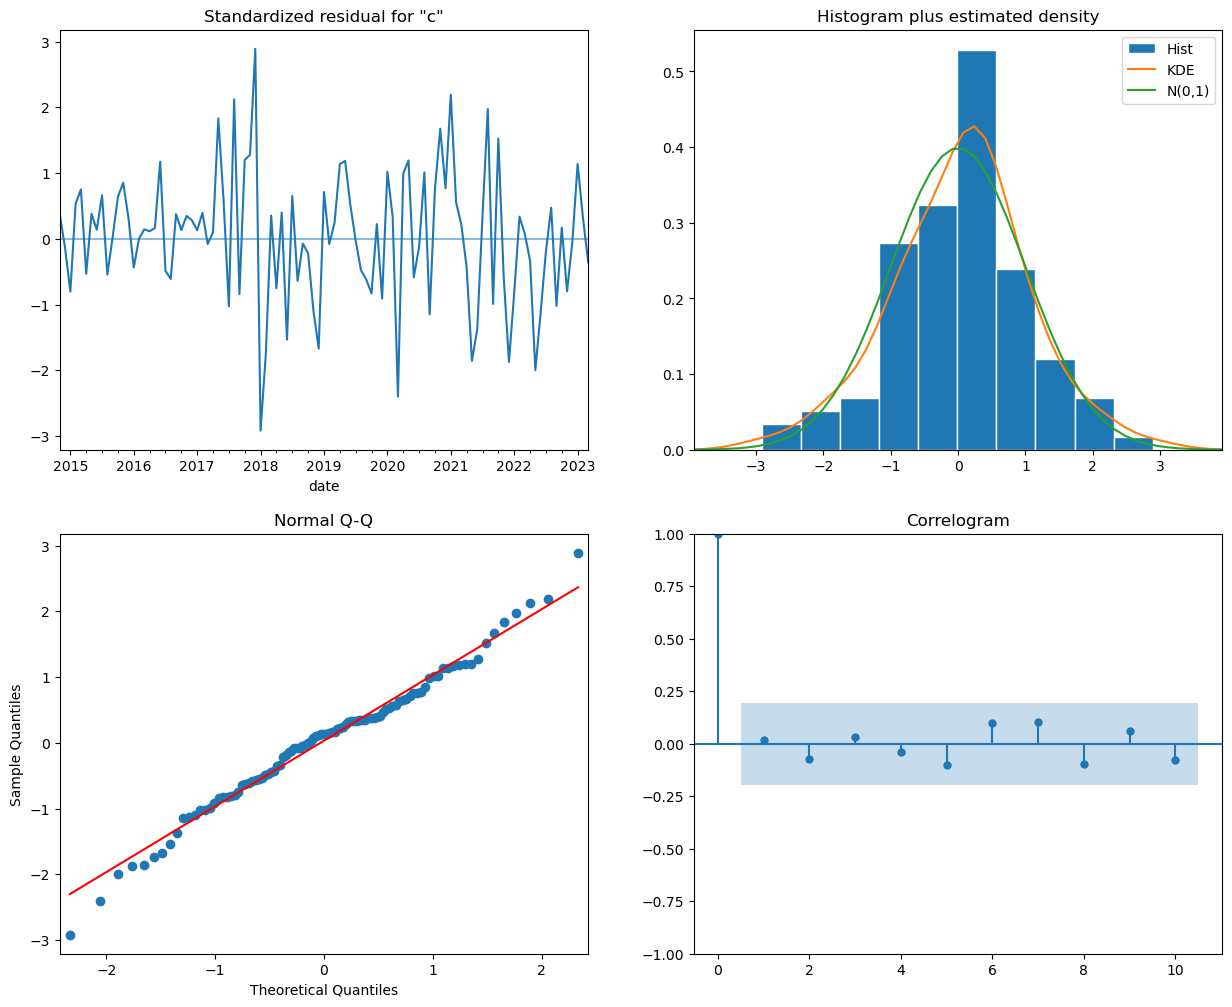

In [121]:
best_model.plot_diagnostics(figsize = (15, 12))
plt.show()

Our primary concern is to ensure that the residuals of our models are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

In the histogram (top right), the KDE line should follow the N(0, 1) line (normal distribution with mean 0, standard deviation 1) closely. This is an indication whether the residuals are normally distributed or not.

In the Q-Q-plot the ordered distributio nof residuals (blue dots) should follow the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is an indication whether the residuals are normally distributed.

The standardized residual plot doesn't display any obvious seasonality. This is confirmed by the autocorrelation plot, which shows that the time series residuals have low correlation with lagged version of itself

Conclusion: We may consider trying to standardize the distribution further. But let's go ahead and do a prediction anyway.

### Prediction

In [122]:
# Inverse Box-Cox Transformation Function
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda * y + 1) / lmbda))

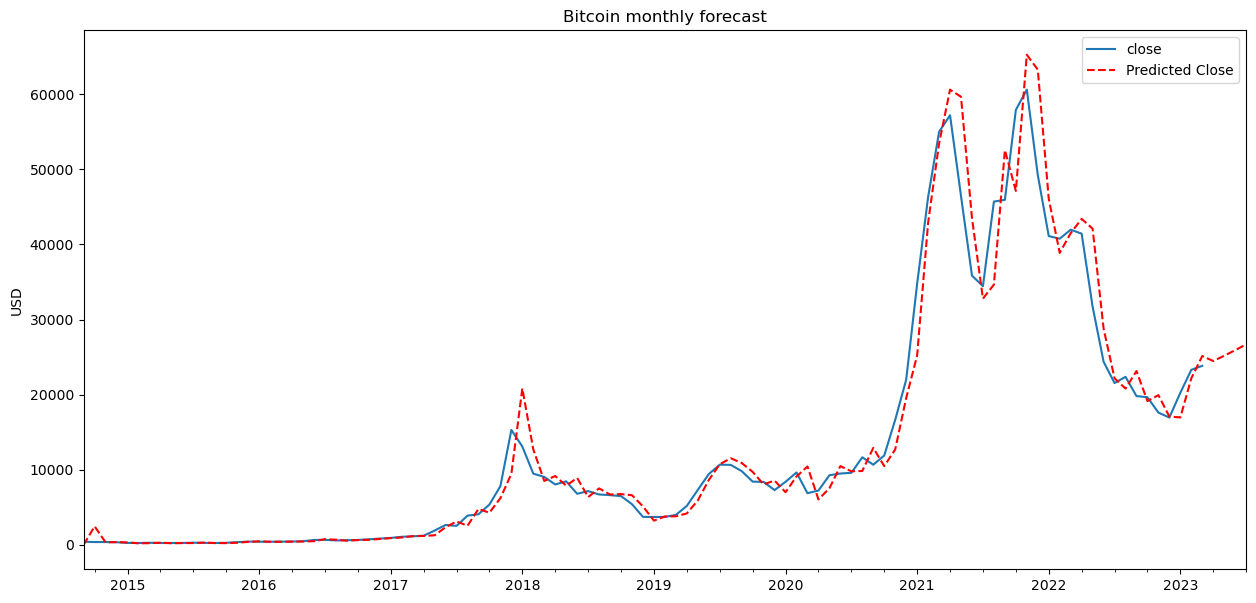

In [123]:
# Prediction
btc_month_pred = btc_month[['close']]
# date_list - [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30), datetime(2018, 7, 31), datetime(2018, 8, 31), datetime(2018, 9, 30), datetime(2018, 10, 31), datetime(2018, 11, 30), datetime(2018, 12, 31)]
date_list = [datetime(2023, 4, 30), datetime(2023, 5, 31), datetime(2023, 6, 30), datetime(2023, 7, 31)]
future = pd.DataFrame(index = date_list, columns= btc_month.columns)
btc_month_pred = pd.concat([btc_month_pred, future])

# btc_month_pred['forecast'] = invboxcox(best_model.predict(start = 0, end = 75), lmbda)
btc_month_pred['forecast'] = invboxcox(best_model.predict(start = datetime(2014, 9, 30), end = datetime(2023, 7, 31)), lmbda)

plt.figure(figsize = (15, 7))
btc_month_pred.close.plot()
btc_month_pred.forecast.plot(color = 'r', ls = '--', label = 'Predicted Close')
plt.legend()
plt.title('Bitcoin monthly forecast')
plt.ylabel('USD')
plt.show()



# SARIMAX Model

Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model

Apparently bitcoin data does display slight seasonality. So let's try to improve the model by using SARIMAX

When dealing with seasonal effects, we make use of seasonal ARIMA, which is denoted as ARIMA(p, d, q)(P, D, Q)s. Here, (p, d, q) are the non-seasonal parameters described above, while(P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The terms is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.)

In [124]:
# Initial approximation of parameters
Qs = range(0, 3)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D = 1
d = 1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float('inf')
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        # model = SARIMAX(btc_month.close_box, order = (param[0], d, param[1]), seasonal_order = (param[2], D, param[3], 12)).fit(disp = -1)
        model = SARIMAX(btc_month.close_box, order = (param[0], d, param[1]), seasonal_order = (param[2], D, param[3], 4)).fit(disp = -1)
    except ValueError:
        print('bad parameter combination: ', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [125]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending = True).head())
print(best_model.summary())

      parameters         aic
19  (1, 0, 0, 1)  200.003680
7   (0, 1, 0, 1)  200.426753
25  (1, 1, 0, 1)  201.526100
37  (2, 0, 0, 1)  201.648871
13  (0, 2, 0, 1)  201.734006
                                      SARIMAX Results                                      
Dep. Variable:                           close_box   No. Observations:                  103
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 4)   Log Likelihood                 -97.002
Date:                             Sun, 26 Mar 2023   AIC                            200.004
Time:                                     18:01:54   BIC                            207.759
Sample:                                 09-30-2014   HQIC                           203.140
                                      - 03-31-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------

##### Analysis of Results

In [88]:
print('Dickey-Fuller test: p=%f' % adfuller(best_model.resid[13:])[1])

Dickey-Fuller test: p=0.000000


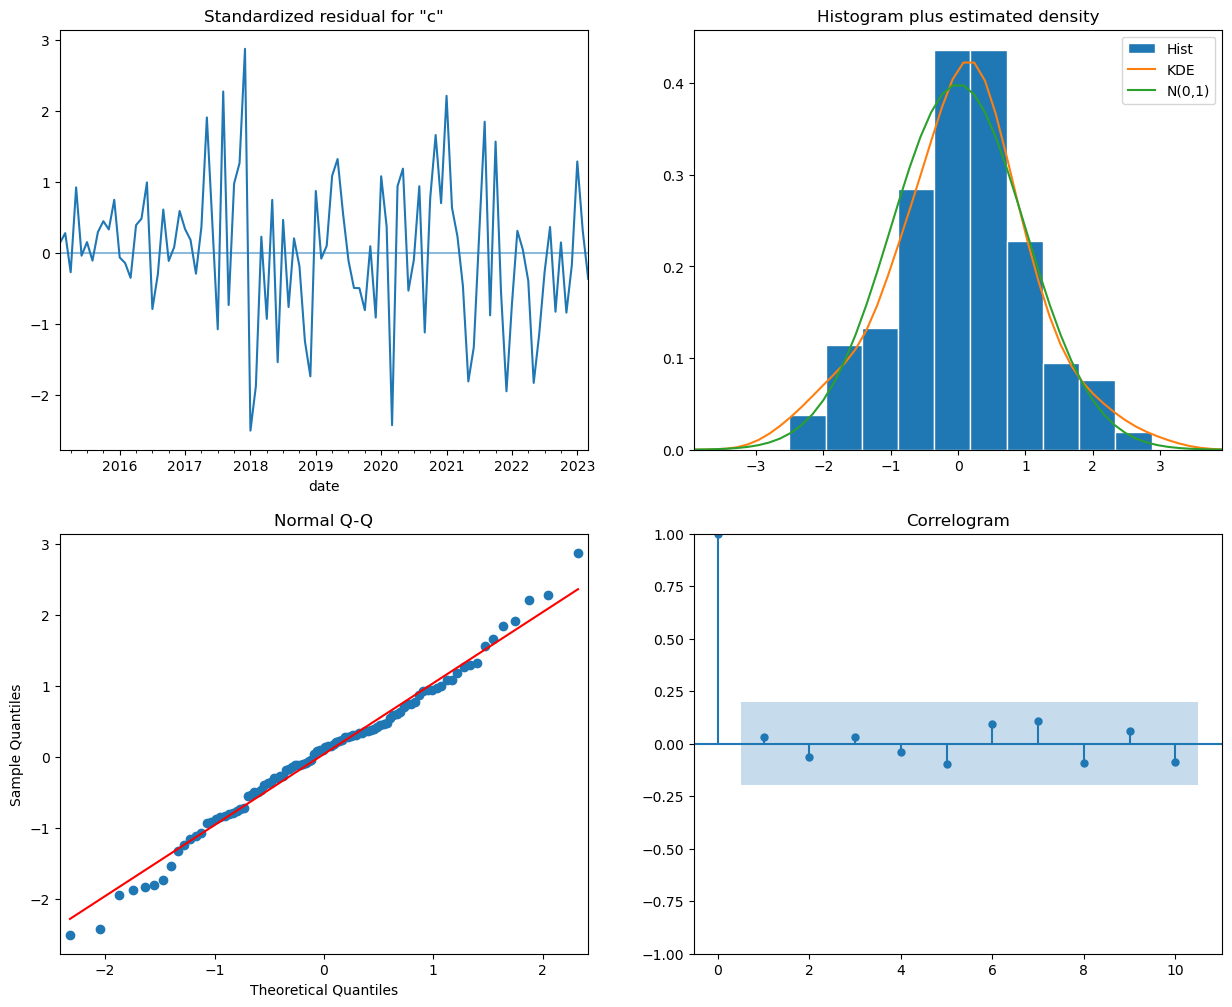

In [89]:
best_model.plot_diagnostics(figsize = (15, 12))
plt.show()

Dickey-Fuller test: p=0.000000


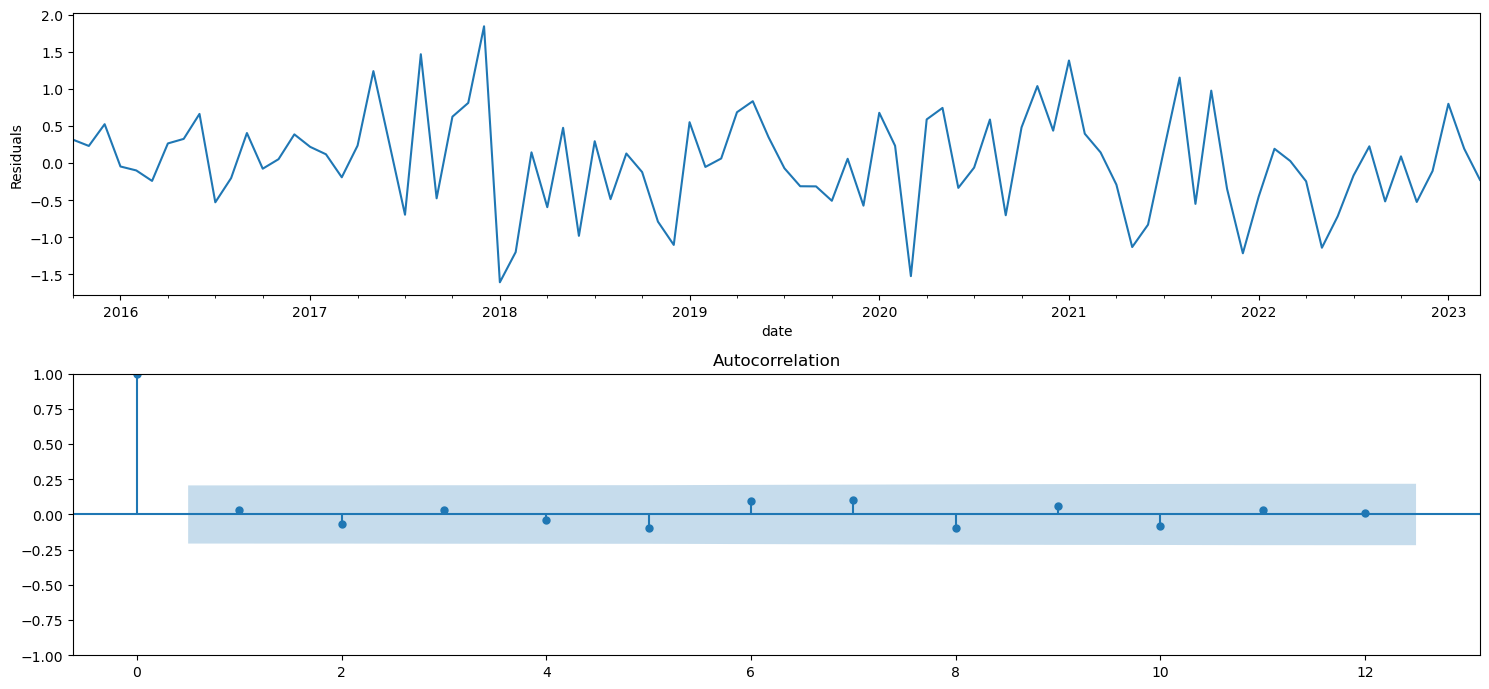

In [90]:
# STL_decomposition
plt.figure(figsize = (15, 7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
# sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags = 48, ax = ax)
plot_acf(best_model.resid[13:].values.squeeze(), lags = 12, ax = ax)

print('Dickey-Fuller test: p=%f' % adfuller(best_model.resid[13:])[1])

plt.tight_layout()
plt.show()

### Prediction

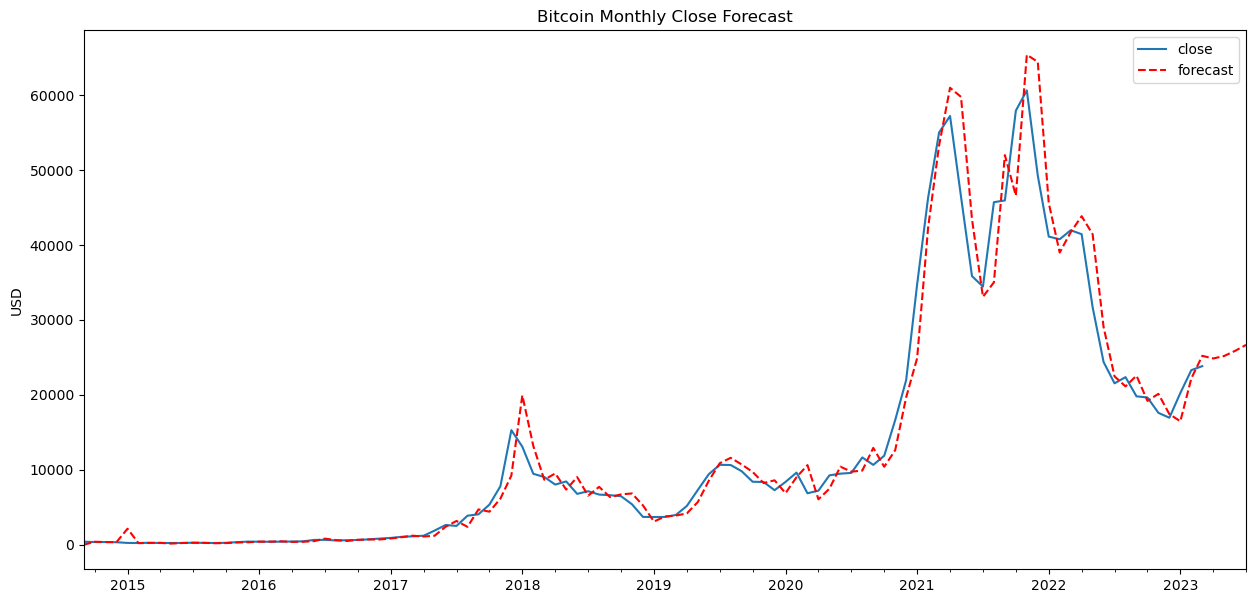

In [91]:
# Prediction
btc_month2 = btc_month[['close']]
date_list = [datetime(2023, 4, 30), datetime(2023, 5, 31), datetime(2023, 6, 30), datetime(2023, 7, 31)]
future = pd.DataFrame(index = date_list, columns = btc_month.columns)
btc_month2 = pd.concat([btc_month2, future])

btc_month2['forecast'] = invboxcox(best_model.predict(start = datetime(2014, 9, 30), end = datetime(2023, 7, 31)), lmbda)

plt.figure(figsize = (15, 7))
btc_month2.close.plot()
btc_month2.forecast.plot(color = 'r', ls = '--', label = 'forecast')
plt.legend()
plt.title('Bitcoin Monthly Close Forecast')
plt.ylabel('USD')
plt.savefig('bitcoin_monthly_forecast.png')
plt.show()

### Validation

A simple indicator of how accurate out forecast is is the root mean square error (RMSE). So let's calculate RMSE for the one-step predictions starting from 2017, through to the end of 2021

In [92]:
y_forecasted = btc_month2.forecast
y_truth = btc_month2['2017-01-01' : '2021-01-01'].close

# Compute the root mean squared error
rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('Root Mean Squared Error: {}'.format(round(rmse, 2)))

Root Mean Squared Error: 1953.7


### Dynamic Forecast

A better representation of longer-term predictive power can be obtained using dynamic forecasts In this case, we only use information from the time series up to a certain point, and after that, forecasts are generated using values from previous forecasted time points

In the code chunk below, we specify to start computing the dunamic forecasts and confidence intervals from mid 2022 onwards

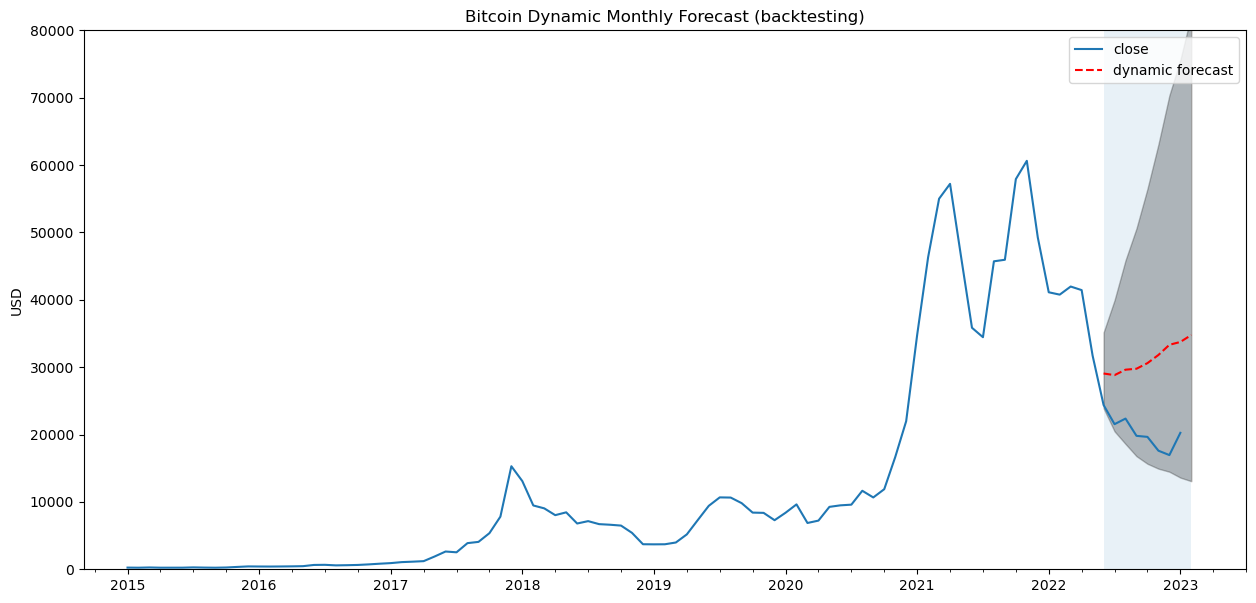

In [126]:
# Get the dynamic forecast between dates t1 and t2
t1 = pd.to_datetime('2022-06-30')
t2 = pd.to_datetime('2023-02-28')
btc_month_dynamic = best_model.get_prediction(start = t1, end = t2, dynamic = True, full_results = True)
btc_month2['dynamic_forecast'] = invboxcox(btc_month_dynamic.predicted_mean, lmbda)

# Taking 80% confidence interval because the 95% blows out too high to visualize
pred_dynamic_ci = btc_month_dynamic.conf_int(alpha = 0.2)
pred_dynamic_ci['lower close_box'] = invboxcox(pred_dynamic_ci['lower close_box'], lmbda)
pred_dynamic_ci['upper close_box'] = invboxcox(pred_dynamic_ci['upper close_box'], lmbda)

# Plot
plt.figure(figsize = (15, 7))
plt.ylim((0, 80000))

btc_month2.close['2015':'2023-01'].plot(label = 'close')
btc_month2.dynamic_forecast.plot(color = 'r', ls = '--', label = 'dynamic forecast')

plt.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color = 'k', alpha = .25)
plt.fill_betweenx(plt.ylim(), t1, t2, alpha = .1, zorder = -1)

plt.legend()
plt.title('Bitcoin Dynamic Monthly Forecast (backtesting)')
plt.ylabel('USD')
plt.show()

This is pretty bad but not surprising given how the prices started going insane around late 2020. Let's see how well the model does in a different time period when things were a little more normal

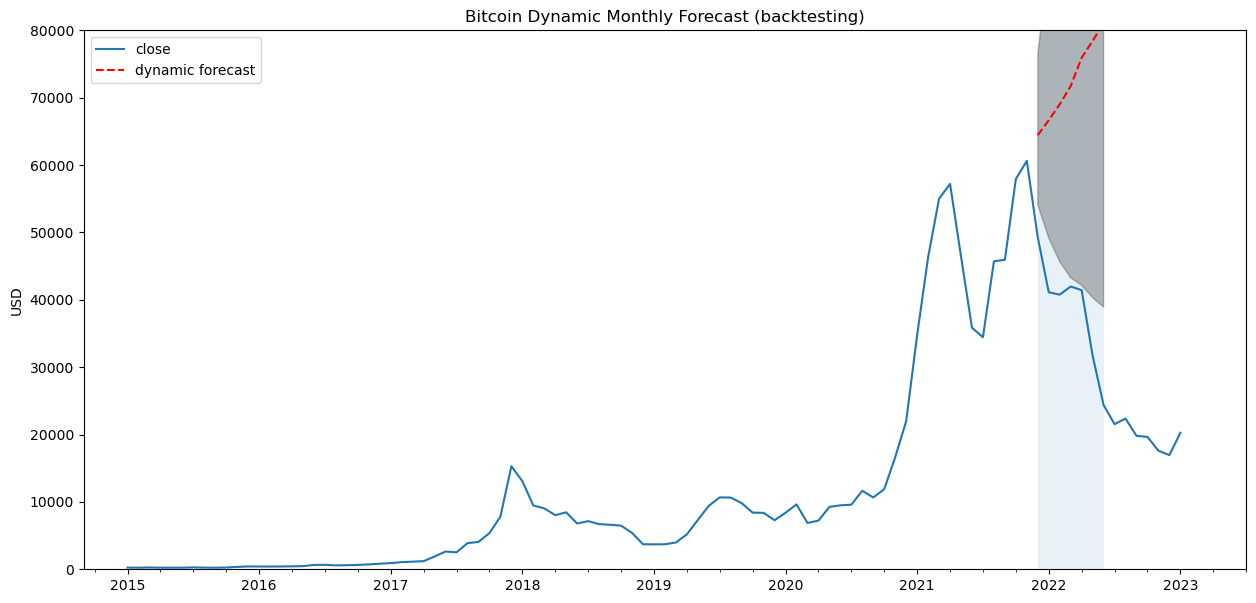

In [127]:
# Get the dynamic forecast between dates t1 and t2
t1 = pd.to_datetime('2021-12-31')
t2 = pd.to_datetime('2022-06-30')
btc_month_dynamic = best_model.get_prediction(start = t1, end = t2, dynamic = True, full_results = True)
btc_month2['dynamic_forecast'] = invboxcox(btc_month_dynamic.predicted_mean, lmbda)

# Taking 80% confidence interval because the 95% blows out too high to visualize
pred_dynamic_ci = btc_month_dynamic.conf_int(alpha = 0.2)
pred_dynamic_ci['lower close_box'] = invboxcox(pred_dynamic_ci['lower close_box'], lmbda)
pred_dynamic_ci['upper close_box'] = invboxcox(pred_dynamic_ci['upper close_box'], lmbda)

# Plot
plt.figure(figsize = (15, 7))
plt.ylim((0, 80000))

btc_month2.close['2015':'2023-01'].plot(label = 'close')
btc_month2.dynamic_forecast.plot(color = 'r', ls = '--', label = 'dynamic forecast')

plt.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color = 'k', alpha = .25)
plt.fill_betweenx(plt.ylim(), t1, t2, alpha = .1, zorder = -1)

plt.legend()
plt.title('Bitcoin Dynamic Monthly Forecast (backtesting)')
plt.ylabel('USD')
plt.show()

The results indicate that the model is still a little rough and not something we should use as trading advice, but that was not unexprected due to the extremely volatile nature of cryptocurrencies, especially in the last 1 year.

It is probably also not such a good idea to try and predict 6 months into the future as we can see how insane even the 80% confidence interval becomes out this far. Maybe sticking to 1 month advance predictions is more sensible. Or maybe even predicting on a daily basis.

There are a number of things we could do to potentially improve the model
- Use a different technique to standardize the distribution
- Use different differentiation techniques
- Discard the time period before ctyptocurrencies started taking off
- Try modelling per day instead of month, with a smaller forecast window
- Use other models or machine learning instead of ARIMA